# Feature Engineering: `patsy` as `FormulaTransformer`

In this notebook I want to describe how to create features inside [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html) using [patsy-like formulas](https://patsy.readthedocs.io/en/latest/formulas.html). I have used this approach to generate features in a previous post: [GLM in PyMC3: Out-Of-Sample Predictions](https://juanitorduz.github.io/glm_pymc3/), so I will consider the same data set here for the sake of comparison.

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import StandardScaler

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '0.9', 'grid.color': '0.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['figure.dpi'] = 100

## Generate Sample Data
We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [2]:
SEED = 42
np.random.seed(SEED)

# Number of data points.
n = 250
# Create features.
x1 = np.random.normal(loc=0.0, scale=2.0, size=n)
x2 = np.random.normal(loc=0.0, scale=2.0, size=n)
epsilon = np.random.normal(loc=0.0, scale=0.5, size=n)
# Define target variable.
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = 1 / (1 + np.exp(-z))
y = np.random.binomial(n=1, p=p, size=n)

df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))

df.head()

,x1,x2,y
0,0.993428,-2.521768,0
1,-0.276529,1.835724,0
2,1.295377,4.244312,1
3,3.046060,2.064931,1
4,-0.468307,-3.038740,1


This is data set is relatively well balanced:

In [3]:
df['y'].value_counts() / df['y'].shape[0]

0    0.54
1    0.46
Name: y, dtype: float64

Let us now split the data into the given features and the target variable

In [4]:
numeric_features = ['x1', 'x2']

x = df[numeric_features]
y = df['y']

Next, we do a random train-test split.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
  x, y, train_size=0.7, random_state=SEED
)

## Model Pipeline

### Implement `FormulaTransformer`

We can follow [scikit-learn's guide](https://scikit-learn.org/stable/developers/develop.html) to implement custom transformations inside a pipeline. The following transformer creates features from a `formula` as described [here](https://patsy.readthedocs.io/en/latest/formulas.html). Please note that by default it will add an `Intercept` term (i.e. columns of ones). If we do not want this feature we can simply ad a `- 1` inside the formula.

In [6]:
class FormulaTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, formula):
        self.formula = formula
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_formula = patsy.dmatrix(formula_like=self.formula, data=X)
        columns = X_formula.design_info.column_names
        return pd.DataFrame(X_formula, columns=columns)

### Define and Fit the Model Pipeline

Now we define and fit our model (see [Column Transformer with Mixed Types guide](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)). We use a $l_2$-regularized logistic regression on a multiplicative interaction of the features. Note that we are not including the intercept in the `formula` but rather in the `estimator` itself.

In [7]:
numeric_transformer = Pipeline(steps=[
    ('formula_transformer', FormulaTransformer(formula='x1 * x2 - 1')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features)
])

estimator = LogisticRegression(
    fit_intercept=True,
    penalty='l2',
    class_weight='balanced'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic_regression', estimator)
])

param_grid = {
    'logistic_regression__C' : np.logspace(start=-2, stop=2, num=20)
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=10
)

grid_search = grid_search.fit(X=x_train, y=y_train)

**Remark:** Note that one could have used the in-build [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) transformer for this particular example. Nevertheless, this *formula* approach can give additional flexibility to explore feature transformations. For example, look how easy is to include *numpy-transformations* (which can actually be encoded using a [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) as well):

In [8]:
formula_transformer = FormulaTransformer(formula='x1 + x2 + np.sin(x1) + np.abs(x2) - 1')
x_train_features = formula_transformer.fit_transform(X=x_train)
x_train_features.head()

,x1,x2,np.sin(x1),np.abs(x2)
0,2.955788,0.151609,0.184737,0.151609
1,-0.583387,-0.770627,-0.550854,0.770627
2,-1.981073,1.744641,-0.917011,1.744641
3,-3.975138,1.256691,0.740319,1.256691
4,1.830804,-1.650994,0.966388,1.650994


Let us visualize the transformed features:

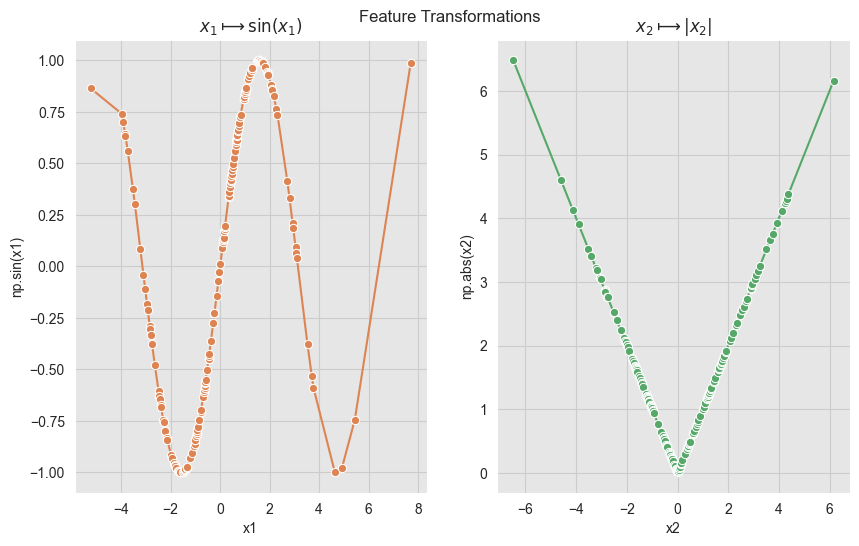

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6)) 
sns.lineplot(x='x1', y='np.sin(x1)', data=x_train_features, marker='o', color=sns_c[1], ax=ax[0])
sns.lineplot(x='x2', y='np.abs(x2)', data=x_train_features, marker='o', color=sns_c[2], ax=ax[1])
ax[0].set(title=r'$x_1 \longmapsto \sin(x_1)$')
ax[1].set(title=r'$x_2 \longmapsto |x_2|$')
fig.suptitle('Feature Transformations', y=0.93);

## Predictions and Evaluation Metrics

Now we simply evaluate the model by looking into its performance in out-of-sample data. The results are similar to the ones in the [previous post](https://juanitorduz.github.io/glm_pymc3/). First let us get generate predictions (both probabilities and predictions) and compute the accuracy:

In [10]:
p_test_pred = grid_search.predict_proba(X=x_test)[:, 1]
y_test_pred = grid_search.predict(X=x_test)

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.827


Now let us plot the confusion matrix:

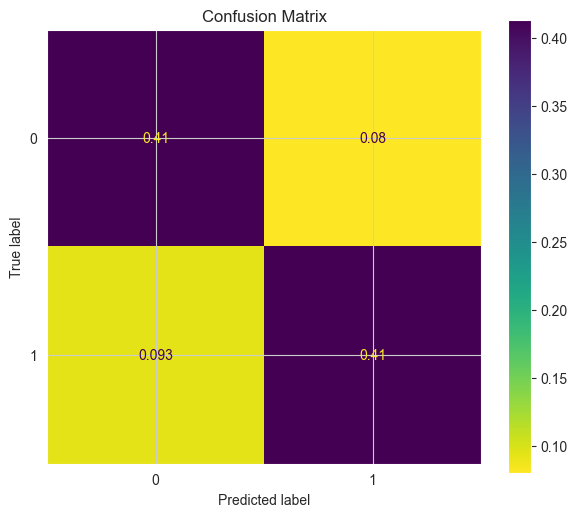

In [11]:
fig, ax = plt.subplots()

plot_confusion_matrix(
    estimator=grid_search, 
    X=x_test,
    y_true=y_test,
    normalize='all',
    cmap='viridis_r',
    ax=ax
)

ax.set(title='Confusion Matrix');

It seems the false positives and false negatives shares are balanced.

Next we look into the [roc curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic):

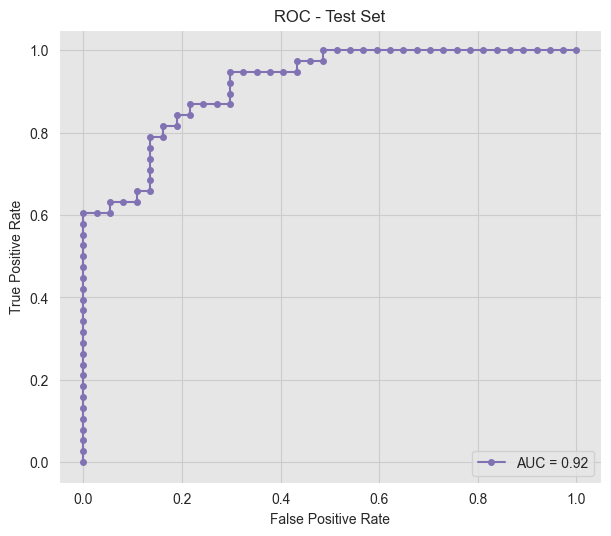

In [12]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", color=sns_c[4], markersize=4)
ax.set(title='ROC - Test Set');

## Partial Dependency Plot

Finally let us compute the [partial dependency plot](https://christophm.github.io/interpretable-ml-book/pdp.html) for both features `x1` and `x2`. First we need to make sure the features are not highly correlated:

In [13]:
print(f'Input features correlation: {x_test.corr().loc["x1", "x2"]: 0.3f}')

Input features correlation:  0.086


Now let us visualize the plot:

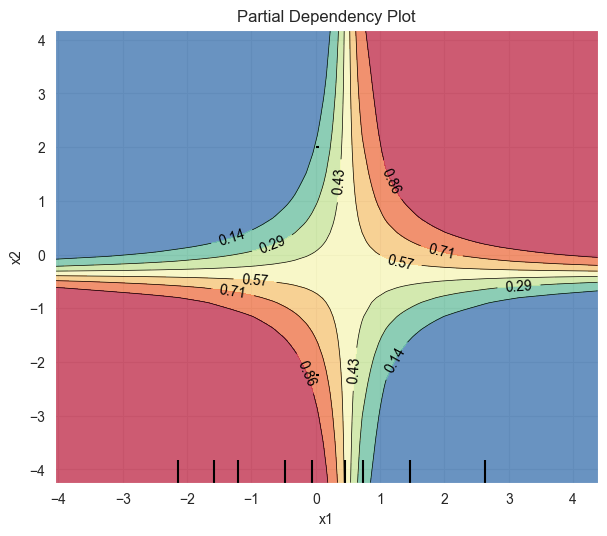

In [14]:
fig, ax = plt.subplots()

cmap = sns.color_palette('Spectral_r', as_cmap=True)

plot_partial_dependence(
    estimator=grid_search,
    X=x_test,
    features=[('x1', 'x2')],
    contour_kw={'cmap': cmap},
    ax=ax
)

ax.set(title='Partial Dependency Plot');

Note how similar it looks as compared with the model decision boundary in the [previous post](https://juanitorduz.github.io/glm_pymc3/).